#  Mission2: 배출 규모 가늠하기

**굴뚝 높이 추정 (Height Estimation from Images)**

- Kompsat-3/3A 위성 이미지 (Training)TS_KS 폴더 내 데이터 8,052개로 학습, Validation)VS_KS 폴더 내 데이터 1,006개로 평가), 라벨링 데이터로 TL_KS_LINE, VL_KS_LINE 을 사용(높이 추정에서는 각 라벨링 데이터 내 shape_attributes 값 사용 가능)

- ResNet 등의 모델을 자유롭게 활용하여 이미지 내 굴뚝의 높이를 meter 단위로 예측하시오

- RMSE 지표를 기반으로 평가함

- “region_attributes”:{“chi_id”:”1”,”chi_height_m”:”187.28”}

**조건**

1. 주어진 데이터에서 file_attributes값은 사용 불가함 (사진 해상도, 각도)

2. train, validation 두 데이터셋에서 shape_attribute 값 (굴뚝 위치)은 제공됨

3. validation 셋에서는 기본적인 augmentation (회전, 리사이즈 등) 외의 “shape_attribution을 활용한“ 이미지 변형(crop 등) 은 불가능함

4. 별도의 inference 제한 없음

# **EDA**

**라벨링 데이터 구조 및 내용 확인**

- 높이, 아이디, 제공자명, 시간, 넓이 등 내용 담겨 있음
- 구조 확인 : 각 객체가 polyline(좌표 배열)형태로 저장되어 있어 이미지 처리를 위해서는 해당 좌표에서 bbox(x,y,width,height)로 변환 필요성을 파악함

In [ ]:
import json

path = "/content/drive/MyDrive/대기오염 배출원 공간 분포 데이터/Training/02.라벨링데이터/TL_KS_LINE/K3_CHN_20210518050720_36.json"
with open(path, "r", encoding="utf-8") as f:
    data = json.load(f)

import pprint
pprint.pprint(data, depth=3)

{'K3_CHN_20210518050720_36.jpg58854': {'file_attributes': {'img_height': '512',
                                                           'img_id': 'K3_CHN_20210518050720_36',
                                                           'img_pitch_tilt': '-17.167585',
                                                           'img_provided': '한국항공우주연구원',
                                                           'img_resolution': '0.7',
                                                           'img_roll_tilt': '-16.71936769',
                                                           'img_time': '21051805',
                                                           'img_width': '512',
                                                           'provided_nm': '한국지능정보사회진흥원'},
                                       'filename': 'K3_CHN_20210518050720_36.jpg',
                                       'regions': [{...}, {...}],
                                       'size': 58854}}


In [ ]:
import json
with open("/content/drive/MyDrive/대기오염 배출원 공간 분포 데이터/Training/02.라벨링데이터/TL_KS_LINE/K3_CHN_20210518050720_36.json","r") as f:
    data = json.load(f)
print(json.dumps(data, indent=2))  # 구조 전체 확인

{
  "K3_CHN_20210518050720_36.jpg58854": {
    "filename": "K3_CHN_20210518050720_36.jpg",
    "size": 58854,
    "regions": [
      {
        "shape_attributes": {
          "name": "polyline",
          "all_points_x": [
            202,
            232
          ],
          "all_points_y": [
            384,
            408
          ]
        },
        "region_attributes": {
          "chi_id": "1",
          "chi_height_m": "62.41"
        }
      },
      {
        "shape_attributes": {
          "name": "polyline",
          "all_points_x": [
            231,
            265
          ],
          "all_points_y": [
            384,
            411
          ]
        },
        "region_attributes": {
          "chi_id": "2",
          "chi_height_m": "70.53"
        }
      }
    ],
    "file_attributes": {
      "img_id": "K3_CHN_20210518050720_36",
      "img_height": "512",
      "img_width": "512",
      "img_resolution": "0.7",
      "img_time": "21051805",
      "img_rol

In [ ]:
train_samples = load_annotations(TRAIN_LABEL_DIR, TRAIN_IMAGE_DIR, require_height=True, verbose=True)

Parsing JSONs: 100%|██████████| 8052/8052 [03:06<00:00, 43.11it/s] 

Found 10590 samples.


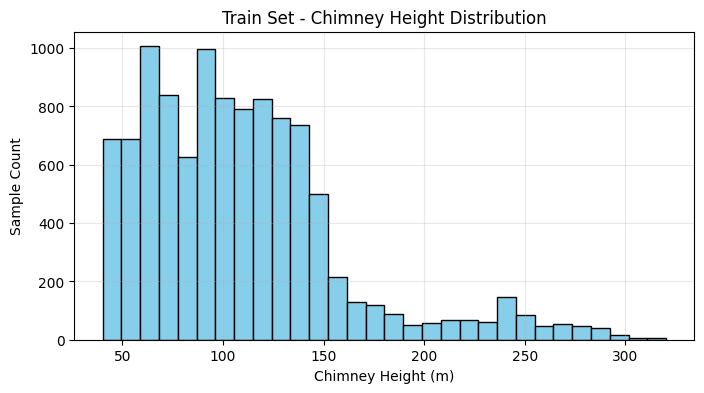

In [ ]:
# 굴뚝 높이 분포 시각화

import matplotlib.pyplot as plt

# 높이값만 추출
heights = [s['height'] for s in train_samples if s['height'] is not None]

plt.figure(figsize=(8, 4))
plt.hist(heights, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Chimney Height (m)')
plt.ylabel('Sample Count')
plt.title('Train Set - Chimney Height Distribution')
plt.grid(alpha=0.3)
plt.show()

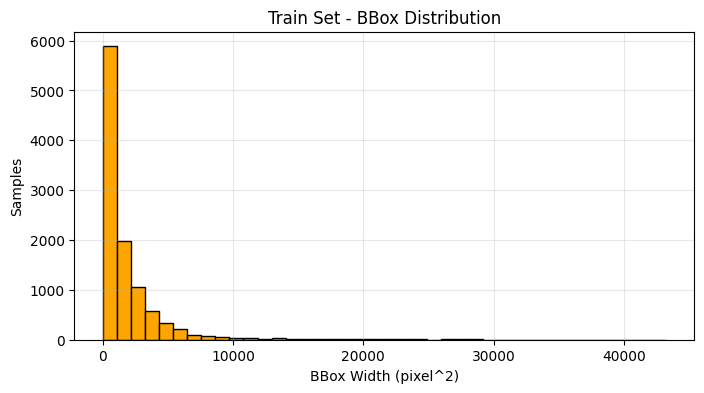

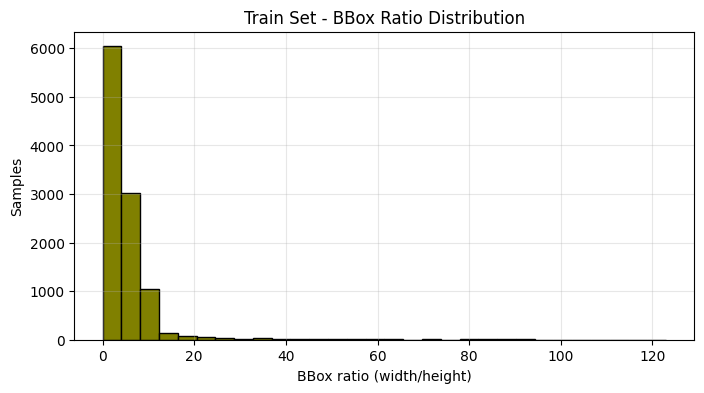

In [ ]:
# BBox 넓이 및 비율 분포 시각화

# bbox에서 가로, 세로 너비 추출
widths = [s['bbox'][2] for s in train_samples]
heights_bbox = [s['bbox'][3] for s in train_samples]

# bbox 넓이 계산
areas = [w*h for w, h in zip(widths, heights_bbox)]

# 넓이 분포 시각화
plt.figure(figsize=(8, 4))
plt.hist(areas, bins=40, color='orange', edgecolor='black')
plt.xlabel('BBox Width (pixel^2)')
plt.ylabel('Samples')
plt.title('Train Set - BBox Distribution')
plt.grid(alpha=0.3)
plt.show()

# 가로/세로 비율 분포 시각화
ratios = [w/h if h != 0 else 0 for w, h in zip(widths, heights_bbox)]

plt.figure(figsize=(8, 4))
plt.hist(ratios, bins=30, color='olive', edgecolor='black')
plt.xlabel('BBox ratio (width/height)')
plt.ylabel('Samples')
plt.title('Train Set - BBox Ratio Distribution')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# 결측 높이값 및 이상치 기본 점검
missing_height = [s for s in train_samples if s['height'] is None]

print(f"총 샘플 수: {len(train_samples)}")
print(f"결측 높이값 샘플 수: {len(missing_height)} (require_height=True 옵션 시 자동 제외됨)")

총 샘플 수: 10590
결측 높이값 샘플 수: 0 (require_height=True 옵션 시 자동 제외됨)


In [ ]:
# 이미지 및 라벨 시각

from PIL import Image
import matplotlib.pyplot as plt

for s in train_samples[:5]:
    img = Image.open(s['img_path']).convert('RGB')
    x, y, w, h = s['bbox']
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(img)
    rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
    ax.add_patch(rect)
    ax.set_title(f"Chimney Heights: {s['height']}m")
    plt.axis('off')
    plt.show()

# **Resnet 활용 모델 생성**

In [ ]:
# 1. 기본 패키지 및 Colab Drive 마운트
import os                        # 경로/파일 관리용
import json                      # 라벨 파일(JSON) 파싱용
import numpy as np               # 숫자, 배열 연산
from tqdm import tqdm            # 진행 바 시각화
from PIL import Image            # 이미지 열기/처리

from google.colab import drive   # 구글 드라이브 연동
drive.mount('/content/drive')

# 2. 프로젝트 데이터 경로 설정
base_project_path = '/content/drive/MyDrive/대기오염 배출원 공간 분포 데이터'
TRAIN_IMAGE_DIR = os.path.join(base_project_path, 'Training/01.원천데이터/TS_KS')
TRAIN_LABEL_DIR = os.path.join(base_project_path, 'Training/02.라벨링데이터/TL_KS_LINE')
VAL_IMAGE_DIR = os.path.join(base_project_path, 'Validation/01.원천데이터/VS_KS')
VAL_LABEL_DIR = os.path.join(base_project_path, 'Validation/02.라벨링데이터/VL_KS_LINE')

Mounted at /content/drive


In [ ]:
import os
import json
from tqdm import tqdm

# 3. polyline 좌표 → bbox (crop 좌표) 변환 함수
def poly_to_bbox(xs, ys):
    x_min, y_min = min(xs), min(ys)
    x_max, y_max = max(xs), max(ys)
    return int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)

# 4. 라벨(JSON) 파싱: 굴뚝 crop과 높이값 샘플화
def load_annotations(json_dir, img_dir, require_height=True, verbose=True):
    json_files = [os.path.join(json_dir, f) for f in os.listdir(json_dir) if f.endswith('.json')]
    samples = []
    for jfile in tqdm(json_files, desc='Parsing JSONs'):
        with open(jfile, encoding='utf-8') as f:
            data = json.load(f)
        for item in data.values():
            fname = item.get('filename')
            img_path = os.path.join(img_dir, fname)
            for region in item.get('regions', []):
                xs = region['shape_attributes']['all_points_x']
                ys = region['shape_attributes']['all_points_y']
                bbox = poly_to_bbox(xs, ys)
                try:
                    height = float(region['region_attributes']['chi_height_m'])
                except:
                    if require_height: continue  # 높이 라벨이 없으면 넘김
                    height = None
                samples.append({'img_path': img_path, 'bbox': bbox, 'height': height})
    if verbose:
        print(f"Found {len(samples)} samples.")
    return samples

In [ ]:
# 5. Stratified 방식으로 train/val 분할(레이블 분포 보존)
import numpy as np
from sklearn.model_selection import train_test_split

def stratified_split(samples, test_size=0.2, random_state=42, n_bins=8):
    heights = np.array([s['height'] for s in samples])
    bins = np.linspace(heights.min(), heights.max(), n_bins+1)
    labels = np.digitize(heights, bins[1:-1])
    idx = np.arange(len(samples))
    train_idx, val_idx = train_test_split(idx, test_size=test_size, random_state=random_state, stratify=labels)
    train_samples = [samples[i] for i in train_idx]
    val_samples = [samples[i] for i in val_idx]
    return train_samples, val_samples

In [ ]:
# 6. PyTorch Dataset 생성 (이미지 crop + 라벨 height 얻기)
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class ChimneyDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        s = self.samples[idx]
        x, y, w, h = s['bbox']
        img = Image.open(s['img_path']).convert('RGB').crop((x, y, x+w, y+h))
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor([s['height']], dtype=torch.float32)

# 7. 이미지 증강/정규화 transform
train_transform = T.Compose([
    T.Resize((224,224)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.2, 0.2, 0.2, 0.1),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

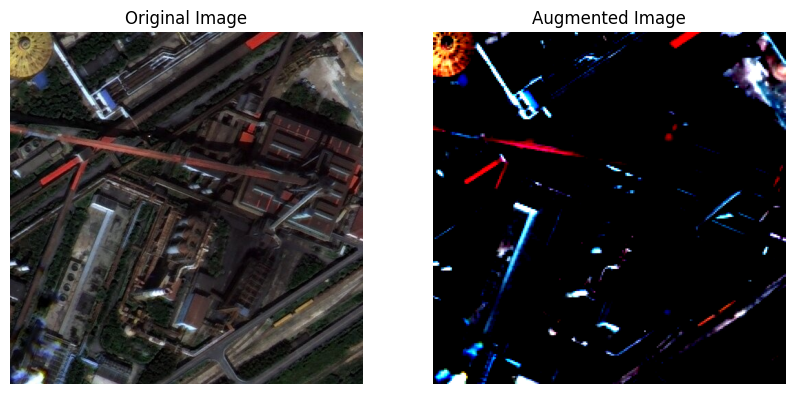

In [ ]:
# 증강 효과 시각(train_transform 전후 비교)

import matplotlib.pyplot as plt

# train_transform 적용 (1개 샘플)
from torchvision import transforms

img = Image.open(train_samples[0]['img_path']).convert('RGB')
img_orig = img.copy()
img_aug = train_transform(img)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_orig)
axes[0].set_title("Original Image")
axes[0].axis("off")

# tensor -> numpy 변환 후 출력
axes[1].imshow(img_aug.permute(1, 2, 0).numpy())
axes[1].set_title("Augmented Image")
axes[1].axis("off")
plt.show()

In [ ]:
# 8. DataLoader로 PyTorch 배치 데이터 구성
def build_loaders(train_samples, val_samples, batch_size=32):
    train_ds = ChimneyDataset(train_samples, transform=train_transform)
    val_ds = ChimneyDataset(val_samples, transform=val_transform)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_dl, val_dl

In [ ]:
# 배치 확인
samples = load_annotations(TRAIN_LABEL_DIR, TRAIN_IMAGE_DIR, require_height=True)
train_samples, val_samples = stratified_split(samples)

train_dl, val_dl = build_loaders(train_samples, val_samples)

imgs, labels = next(iter(train_dl))
print("이미지 배치 크기:", imgs.shape)
print("라벨 배치 크기:", labels.shape)


Parsing JSONs: 100%|██████████| 8052/8052 [03:57<00:00, 33.90it/s] 


Found 10590 samples.
이미지 배치 크기: torch.Size([32, 3, 224, 224])
라벨 배치 크기: torch.Size([32, 1])


히스토그램으로 시각화
- training / validation으로 나뉜 높이 분포

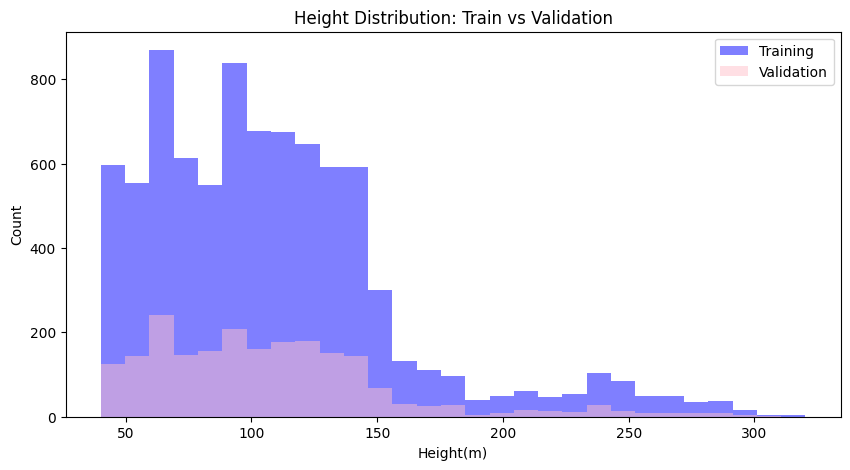

In [ ]:
import matplotlib.pyplot as plt
# height(높이)추출
train_heights = [s["height"]for s in train_samples]
val_heights = [s["height"]for s in val_samples]

#히스토그램 비교
plt.figure(figsize=(10,5))
bins = np.linspace(min(train_heights + val_heights),max(train_heights + val_heights),30)

plt.hist(train_heights, bins=bins, alpha=0.5, label= 'Training', color='blue')
plt.hist(val_heights, bins=bins , alpha=0.5, label='Validation', color='pink')

plt.xlabel('Height(m)')
plt.ylabel('Count')
plt.title('Height Distribution: Train vs Validation')
plt.legend()
plt.show()

#결과 해석
- 분포의 특징
  - 왼쪽(낮은 높이): 40~150m 구간에 샘플이 많이 몰려 있음
   -> 대부분의 굴뚝이 비교적 낮은 편 예측
  - 중간 ~ 오른쪽(높은 높이): 150~300m 구간은 샘플 수가 급격히 줄어듬
  - train vs validation 비율:
    - 겹쳐서 보면, validation 데이터도 전체 패턴을 잘 반영하고 있음
    -> 즉 stratified split이 제대로 작동해서 높이 분포가 training/validation 모두 균형 있게 샘플링 됨.

# 객체 추정 알고리즘
-	모델 접근법
1) ResNet, EfficientNet (CNN기반 알고리즘)
2) VIT
-	먼저 CNN기반 ResNet18 학습 모델 선정

In [ ]:
# 9. 사전학습 ResNet50 불러와서 마지막 레이어만 회귀(1-dim)로 변경
from torchvision import models
import torch.nn as nn

def get_resnet(model_name='resnet50', pretrained=True):
    if model_name == 'resnet18':
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
    elif model_name == 'resnet34':
        model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT if pretrained else None)
    elif model_name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
    else:
        raise ValueError("Invalid model_name.")
    model.fc = nn.Linear(model.fc.in_features, 1)
    return model

In [ ]:
# 10. 학습 및 검증 루프 (각 epoch 손실 계산)
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    loss_sum = 0
    for imgs, labels in tqdm(loader, desc='Train'):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * len(imgs)
    return loss_sum / len(loader.dataset)

def val_one_epoch(model, loader, criterion, device):
    model.eval()
    loss_sum = 0
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc='Val'):
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            loss = criterion(out, labels)
            loss_sum += loss.item() * len(imgs)
    return loss_sum / len(loader.dataset)

In [ ]:
# 11. 데이터 로드 & 분할
samples = load_annotations(TRAIN_LABEL_DIR, TRAIN_IMAGE_DIR)
train_samples, val_samples = stratified_split(samples, test_size=0.2)
train_loader, val_loader = build_loaders(train_samples, val_samples, batch_size=32)

# 12. 모델 선언/학습 (20 에폭) 및 최적 모델 저장
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_resnet('resnet50').to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

best_val_loss = float('inf')
for epoch in range(20):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = val_one_epoch(model, val_loader, criterion, device)
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: train_loss={train_loss:.2f}, val_loss={val_loss:.2f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(base_project_path, 'best_resnet.pth'))
        print("  Best model saved!")

Parsing JSONs: 100%|██████████| 8052/8052 [04:31<00:00, 29.64it/s] 


Found 10590 samples.
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]
Val: 100%|██████████| 67/67 [08:18<00:00,  7.44s/it]


Epoch 1: train_loss=6922.24, val_loss=2671.28
  Best model saved!


Val: 100%|██████████| 67/67 [00:13<00:00,  4.82it/s]


Epoch 2: train_loss=995.33, val_loss=507.72
  Best model saved!


Val: 100%|██████████| 67/67 [00:14<00:00,  4.72it/s]


Epoch 3: train_loss=585.57, val_loss=448.02
  Best model saved!


Val: 100%|██████████| 67/67 [00:13<00:00,  4.85it/s]


Epoch 4: train_loss=503.62, val_loss=368.03
  Best model saved!


Val: 100%|██████████| 67/67 [00:14<00:00,  4.76it/s]


Epoch 5: train_loss=414.73, val_loss=346.17
  Best model saved!


Val: 100%|██████████| 67/67 [00:14<00:00,  4.77it/s]


Epoch 6: train_loss=373.79, val_loss=281.77
  Best model saved!


Val: 100%|██████████| 67/67 [00:14<00:00,  4.76it/s]


Epoch 7: train_loss=337.61, val_loss=263.21
  Best model saved!


Val: 100%|██████████| 67/67 [00:14<00:00,  4.70it/s]


Epoch 8: train_loss=318.69, val_loss=242.61
  Best model saved!


Val: 100%|██████████| 67/67 [00:14<00:00,  4.72it/s]


Epoch 9: train_loss=277.52, val_loss=240.09
  Best model saved!


Val: 100%|██████████| 67/67 [00:14<00:00,  4.74it/s]


Epoch 10: train_loss=243.36, val_loss=226.60
  Best model saved!


Val: 100%|██████████| 67/67 [00:14<00:00,  4.77it/s]


Epoch 11: train_loss=216.81, val_loss=245.62


Val: 100%|██████████| 67/67 [00:13<00:00,  4.83it/s]


Epoch 12: train_loss=226.56, val_loss=185.89
  Best model saved!


Val: 100%|██████████| 67/67 [00:14<00:00,  4.68it/s]


Epoch 13: train_loss=202.88, val_loss=176.96
  Best model saved!


Val: 100%|██████████| 67/67 [00:13<00:00,  4.84it/s]


Epoch 14: train_loss=212.18, val_loss=182.36


Val: 100%|██████████| 67/67 [00:14<00:00,  4.66it/s]


Epoch 15: train_loss=187.91, val_loss=219.38


Val: 100%|██████████| 67/67 [00:14<00:00,  4.66it/s]


Epoch 16: train_loss=176.61, val_loss=171.60
  Best model saved!


Val: 100%|██████████| 67/67 [00:14<00:00,  4.75it/s]


Epoch 17: train_loss=165.01, val_loss=170.67
  Best model saved!


Val: 100%|██████████| 67/67 [00:14<00:00,  4.77it/s]


Epoch 18: train_loss=156.89, val_loss=183.10


Val: 100%|██████████| 67/67 [00:14<00:00,  4.54it/s]


Epoch 19: train_loss=149.88, val_loss=160.92
  Best model saved!


Val: 100%|██████████| 67/67 [00:14<00:00,  4.63it/s]

Epoch 20: train_loss=146.02, val_loss=190.41


RMSE: 13.80, MAE: 10.06, R2: 0.92


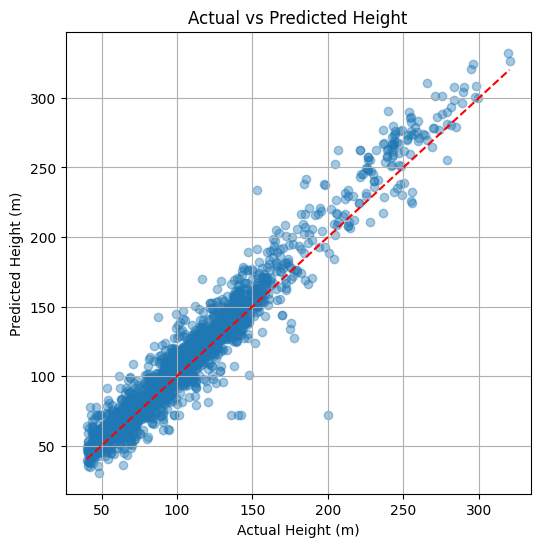

In [ ]:
# 13. 검증 성능 평가(RMSE, MAE, R2) 및 산점도 시각화 함수
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def eval_model(model, loader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for imgs, labs in loader:
            imgs = imgs.to(device)
            out = model(imgs).cpu().numpy().flatten()
            preds.append(out)
            labels.append(labs.numpy().flatten())
    preds = np.concatenate(preds)
    labels = np.concatenate(labels)
    rmse = np.sqrt(mean_squared_error(labels, preds))
    mae = mean_absolute_error(labels, preds)
    r2 = r2_score(labels, preds)
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")
    return labels, preds

def plot_predictions(labels, preds):
    plt.figure(figsize=(6,6))
    plt.scatter(labels, preds, alpha=0.4)
    plt.plot([labels.min(), labels.max()], [labels.min(), labels.max()], 'r--')
    plt.xlabel('Actual Height (m)')
    plt.ylabel('Predicted Height (m)')
    plt.title('Actual vs Predicted Height')
    plt.grid(True)
    plt.show()

# 14. 평가 및 시각화 실행
labels, preds = eval_model(model, val_loader, device)
plot_predictions(labels, preds)

In [ ]:
# 15. Validation 데이터 경로 설정
VAL_IMAGE_DIR = os.path.join(base_project_path, 'Validation/01.원천데이터/VS_KS')
VAL_LABEL_DIR = os.path.join(base_project_path, 'Validation/02.라벨링데이터/VL_KS_LINE')

# 16. Validation 라벨 불러오기
val_samples = load_annotations(VAL_LABEL_DIR, VAL_IMAGE_DIR, require_height=True, verbose=True)

# 17. Dataset 및 Transform 지정
val_dataset = ChimneyDataset(val_samples, transform=val_transform)

Parsing JSONs: 100%|██████████| 1006/1006 [00:29<00:00, 34.28it/s] 

Found 1323 samples.


In [ ]:
# 18. 모델을 평가 모드로 전환
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

# 19. 검증용 Validation set 중 10개 무작위 샘플 추출 (중복X)
n_samples = min(10, len(val_dataset))
indices = random.sample(range(len(val_dataset)), n_samples)
samples = [val_dataset[i] for i in indices]

# 20. 각 샘플에서 원본 이미지, 예측값, 실제 bbox/height 표시
for idx in indices:
    s = val_samples[idx]
    img_path = s['img_path']
    bbox = s['bbox']
    x, y, w, h = bbox
    gt = s['height']

    # (a) 원본 위성 이미지 전체 불러오기 (정밀 시각화용)
    orig_img = Image.open(img_path).convert('RGB')

    # (b) 모델이 예측하는 부분 = bbox crop → transform → 예측값 추출
    crop_img = orig_img.crop((x, y, x+w, y+h))          # 굴뚝 bbox로 잘라냄
    img_tensor = val_transform(crop_img)                # 모델 입력 전처리 적용
    img_input = img_tensor.unsqueeze(0).to(device)      # 배치 크기(1)로 차원 추가 후 GPU/CPU 전송
    pred = model(img_input).item()                      # 예측 높이값(실수) 추출

    # (c) 시각화
    img_show = np.array(orig_img)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_show)
    ax = plt.gca()

    # 🔵 실제 굴뚝 GT(정답) bbox 위치(파란색 사각형) + 정답 높이
    rect_gt = plt.Rectangle((x, y), w, h, fill=False, color="blue", linewidth=2, linestyle="--")
    ax.add_patch(rect_gt)
    ax.text(x, y-10, f"GT: {gt:.2f}m", color="blue", fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

    # 🔴 예측 height 값 (박스 아래에 빨간 텍스트)
    ax.text(x, y+h+15, f"Pred: {pred:.2f}m", color="red", fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

    plt.axis("off")
    plt.title(f"Validation Sample {idx+1} (Blue: GT, Red: Pred)")
    plt.show()

In [ ]:
# best 모델 저장
save_path = os.path.join(base_project_path, 'best_resnet.pth')
torch.save(model.state_dict(), save_path)
print(f"모델이 {save_path}로 저장되었습니다.")

모델이 /content/drive/MyDrive/대기오염 배출원 공간 분포 데이터/best_resnet.pth로 저장되었습니다.


In [ ]:
# validation set 전체 불러오기 (1,006개)
VAL_IMAGE_DIR = os.path.join(base_project_path, 'Validation/01.원천데이터/VS_KS')
VAL_LABEL_DIR = os.path.join(base_project_path, 'Validation/02.라벨링데이터/VL_KS_LINE')
val_samples = load_annotations(VAL_LABEL_DIR, VAL_IMAGE_DIR, require_height=True, verbose=True)
print(f"전체 validation 샘플 수: {len(val_samples)}")   # → 1006개 확인

Parsing JSONs: 100%|██████████| 1006/1006 [00:12<00:00, 82.28it/s]

Found 1323 samples.
전체 validation 샘플 수: 1323


In [ ]:
import random
random.seed(42)  # 결과 재현성을 위해

all_indices = list(range(len(val_samples)))
test_indices = random.sample(all_indices, 6)               # 6개는 테스트/시각화 전용
val_indices = [i for i in all_indices if i not in test_indices]  # 나머지 1000개 검증

# 검증, 테스트 dataset 나누기
val_samples_1000 = [val_samples[i] for i in val_indices]
test_samples_6 = [val_samples[i] for i in test_indices]

In [ ]:
# 평가용 검증세트 DataLoader
val_dataset_1000 = ChimneyDataset(val_samples_1000, transform=val_transform)
val_loader_1000 = DataLoader(val_dataset_1000, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
def eval_model(model, loader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for imgs, labs in loader:
            imgs = imgs.to(device)
            out = model(imgs).cpu().numpy().flatten()
            preds.append(out)
            labels.append(labs.numpy().flatten())
    preds = np.concatenate(preds)
    labels = np.concatenate(labels)
    rmse = np.sqrt(mean_squared_error(labels, preds))
    mae = mean_absolute_error(labels, preds)
    r2 = r2_score(labels, preds)
    print(f"[1000개 전체] RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")
    return labels, preds

labels_1000, preds_1000 = eval_model(model, val_loader_1000, device)

[1000개 전체] RMSE: 14.48, MAE: 10.22, R2: 0.91
